#**Autoencoder:**#

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms, datasets, utils, models
from torchsummary import summary
import matplotlib.pyplot as plt
from PIL import Image

Start by a simple example. We're going to create two point clouds, with two different centers.

In [2]:
n = 100
D1 = torch.tensor([2,2,0]) + torch.randn(100, 3)
D2 = torch.tensor([-2,-2,0]) + torch.randn(100, 3)

Text(0.5, 0, 'x3')

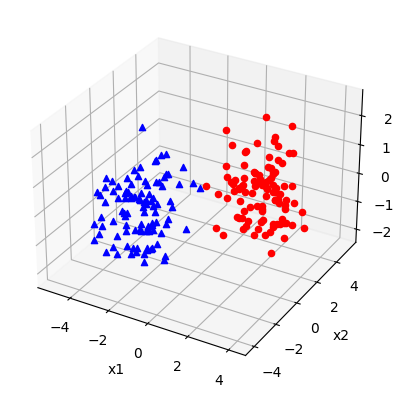

In [3]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

for x in D1.numpy():
  ax.scatter(x[0],x[1],x[2], color='red', marker='o')

for x in D2.numpy():
  ax.scatter(x[0],x[1],x[2], color='blue', marker='^')


ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')


Note that data is seperated by the first two coordinates (i.e. $x_1, x_2$), and the third coordinate (i.e. $x_3$) is acting more as a noise (in separating the two point clouds).

Then define and create the autoencoder. Here we first use a very simple, single-layer neural network for both the encoding and decoding maps.

In [4]:
class autoencoder(torch.nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, input_dim),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

We now define the loss function (quadratic loss = MSE) and the optimizer (Adam).

In [5]:
BATCH_SIZE = 20
torch.manual_seed(1)
D = torch.cat([D1,D2])
dataloader = DataLoader(D, batch_size=BATCH_SIZE)
model = autoencoder(3, 2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [6]:
# Training
EPOCHS = 5

model.train()

for epoch in range(EPOCHS):
    for batch in dataloader:
        optimizer.zero_grad()           # Clear gradients w.r.t. parameters
        y_hat = model(batch)            # Forward pass to get output
        loss = criterion(y_hat, batch)  # Calculate loss
        loss.backward()                 # Getting gradients w.r.t. parameters
        optimizer.step()                # Update parameters

Now that the model is trained, we can focus on the encoder and visualize whether it represents the data succinctly in reduced dimensions.

In [7]:
model.eval()
print(f"Original D shape = {D.shape}")
D_encoded = model.encoder(D)
print(f" Encoded D shape = {D_encoded.shape}")

Original D shape = torch.Size([200, 3])
 Encoded D shape = torch.Size([200, 2])


Text(0, 0.5, 'x2')

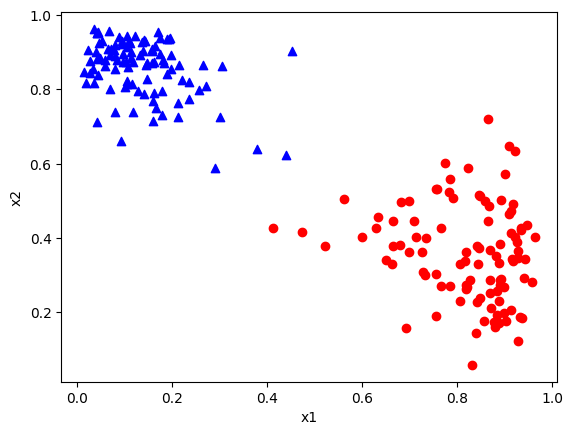

In [8]:
D1_encoded = D_encoded.detach()[0:n,:]
D2_encoded = D_encoded.detach()[n:-1,:]

fig = plt.figure()
ax = fig.add_subplot()

for x in D1_encoded.numpy():
  ax.scatter(x[0],x[1], color='red', marker='o')

for x in D2_encoded.numpy():
  ax.scatter(x[0],x[1], color='blue', marker='^')


ax.set_xlabel('x1')
ax.set_ylabel('x2')

 We trained an autoencoder to effectively reduce the number of features in the data.

Next, we will use the MNIST dataset to tackle more complex tasks.

In [9]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True) #mini-batch size for training is = 64
test_dataloader = DataLoader(test_data, batch_size=8, shuffle=True) #mini-batch size for training is = 8

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:03<00:00, 2.95MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.51MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.2MB/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Again, a super simple autoencoder to start with: one layer for the encoder (linear + relu) and one lienar layer for the decoder.

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Linear(latent_dim, input_dim)
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [11]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(model, optimizer, criterion, EPOCHS, device):

  model = model.to(device)
  model.train()

  for epoch in range(EPOCHS):

    train_loss = 0

    for batch, label in train_dataloader:
        batch = batch.to(device)
        batch = batch.view(batch.size(0),-1) #flattening the data before feeding it into the autoencoder
        optimizer.zero_grad()           # Clear gradients w.r.t. parameters
        y_hat = model(batch)            # Forward pass to get output
        loss = criterion(y_hat, batch)  # Calculate loss
        loss.backward()                 # Getting gradients w.r.t. parameters
        optimizer.step()
        train_loss += loss.item()
    print(epoch, train_loss/len(train_dataloader))
  return model

EPOCHS = 5
model = AutoEncoder(784, 64) #TRY: latent_dim = 16, 32, 64
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

model = train(model, optimizer, criterion, EPOCHS, device)

0 0.029275728975420693
1 0.017340497911047897
2 0.01649672070395019
3 0.01640619652599954
4 0.01606254724622853


Let's take a few data points from `test_dataloader` and observe the outcome.

In [12]:
data, target = next(iter(test_dataloader))
data = data.to(device)
data.shape

torch.Size([8, 1, 28, 28])

The top row contains 8 images from a batch. The bottom row shows the reconstructed versions:

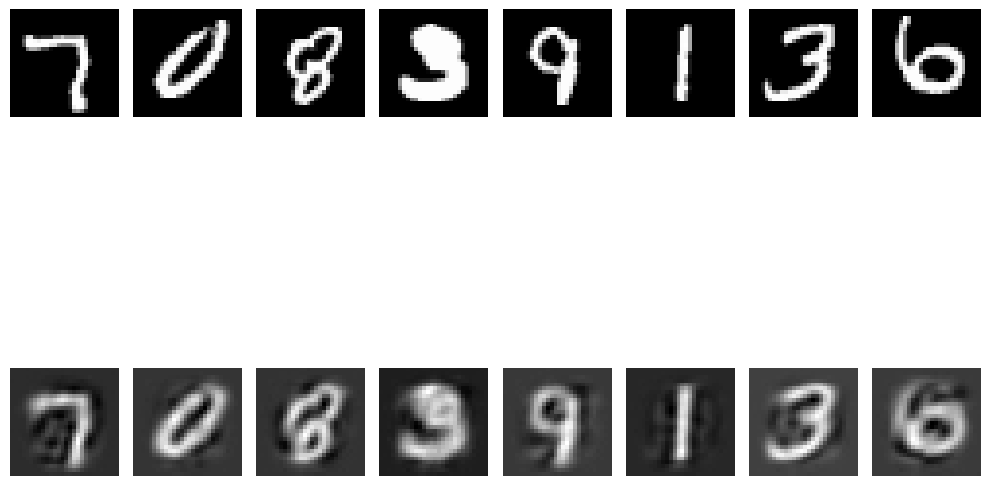

In [13]:
def plot_data_decoded(model, data, devie):

  model.eval()
  figure = plt.figure(figsize=(10, 10))

  data = data.to(device)
  for i in range(8):
    input = data[i,:]
    plt.subplot(2, 8, i+1)
    plt.imshow(input.squeeze(0).cpu(), cmap='gray')
    plt.axis('off')

    y = model(input.view(input.shape[0],-1)).reshape(-1,28,28)
    plt.subplot(2, 8, 8+i+1)
    plt.imshow(y.detach().squeeze(0).cpu().numpy(), cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

data,_ = next(iter(test_dataloader))
plot_data_decoded(model, data, device)

Let's try a complex model with more depth.

We take for the encoder a first hidden layer with dimension 128, a second one with dimension 64 and then the code/laten of dimension laten_dim (e.g. 32). For the decoder, we can take the same sequence of dimensions in reverse order.

In [14]:
class AE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [15]:
#Train with 64 latent dimensions:

model64 = AE(784, 64) #TRY: latent_dim = 16, 32
criterion = nn.MSELoss()
optimizer = optim.Adam(model64.parameters(), lr = 0.002)

EPOCHS = 10

model64 = train(model64, optimizer, criterion, EPOCHS, device)


0 0.032406246891296876
1 0.020304775209044976
2 0.017642819502357163
3 0.016286609254515312
4 0.015366413559057691
5 0.014721847073768756
6 0.014152999507632654
7 0.013677387734624877
8 0.013220962770442083
9 0.012933913533931285


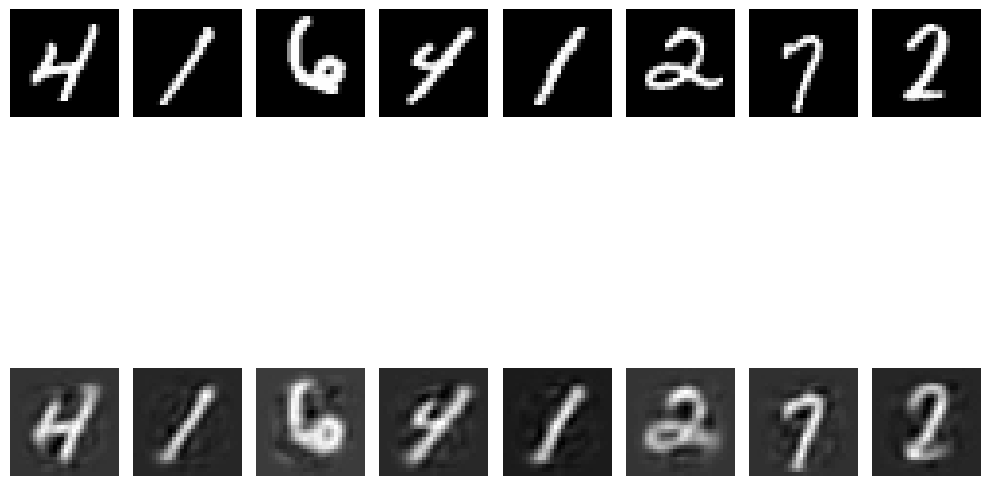

In [16]:
data,_ = next(iter(test_dataloader))
plot_data_decoded(model64, data, device)

What we're going to do next is to take a look at the latent space. To do so, we're gonna let the latent space have only three dimensions (easier to visualize things), and then train the autoencoder and see how two classes (0 and 4) are represented there.

In [33]:
#Train with 3 latent dimensions:

model3 = AE(784,3)
criterion = nn.MSELoss()
optimizer = optim.Adam(model3.parameters(), lr = 0.002)

EPOCHS = 15

model3 = train(model3, optimizer, criterion, EPOCHS, device)

0 0.050283054171848904
1 0.04402933390076354
2 0.04228467690045518
3 0.04132733139386182
4 0.040673895403425066
5 0.04024588257503281
6 0.039697675979626715
7 0.03941502860153535
8 0.03912584205219614
9 0.038899509812087646
10 0.03864726084254698
11 0.038538599007530636
12 0.03834341008907188
13 0.038221103613818884
14 0.03809543178756354


In [34]:
# we'll go over the test data set and put all the data points with label 4 into one tensor, and all with label 0 into another
fours = torch.tensor([])
zeros = torch.tensor([])
for data, targets in test_dataloader:
  idx = targets == 4
  if(len(data[idx]) > 0):
    for i in data[idx]:
      fours = torch.cat([fours, i])

  idx = targets == 0
  if(len(data[idx]) > 0):
    for i in data[idx]:
      zeros = torch.cat([zeros, i])

fours = fours.to(device)
zeros = zeros.to(device)

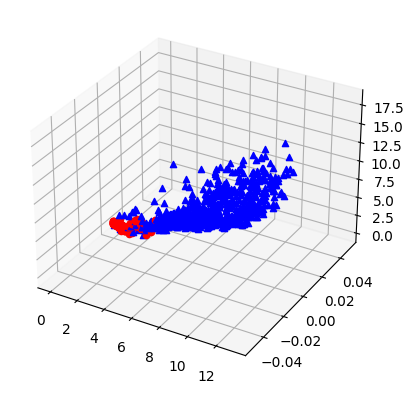

In [35]:
# we will plot the latent representation of the two classes (0 and 4)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

fours_encoded = model3.encoder(fours.view(fours.shape[0],-1))
zeros_encoded = model3.encoder(zeros.view(zeros.shape[0],-1))
for enc in fours_encoded:
  enc = enc.detach().cpu().numpy()
  ax.scatter(enc[0],enc[1],enc[2], color='red', marker='o')
for enc in zeros_encoded:
  enc = enc.detach().cpu().numpy()
  ax.scatter(enc[0],enc[1],enc[2], color='blue', marker='^')


As we can see, the blue samples labeled 0  and the red samples labeled 4 are more clearly separated in the 3d latent space.

This shows that the autoencoder successfully maps the samples of these two categories to different regions of the latent space when the data is encoded, demonstrating the effectiveness of the autoencoder.

## **Transposed Convolutions:**

Transposed convolution, also known as fractionally-strided convolution, is a technique used in convolutional neural networks (CNNs) for the upsampling layer that increases the spatial resolution of an image. It is similar to a deconvolutional layer. A deconvolutional layer reverses the layer to a standard convolutional layer. If the output of the standard convolution layer is deconvolved with the deconvolutional layer then the output will be the same as the original value, while in transposed convolutional value will not be the same, it can reverse to the same dimension.

Let's try a few exmples.

Suppose we have a 2 X 2 input, and we want to upsample it using a transposed convolutional layer with a kernel size of 2 x 2, a stride of 2, and zero padding.

In [20]:
# Input
input = torch.tensor([[0.0, 1.0], [2.0, 3.0]])
# Kernel
kernel = torch.tensor([[1.0, 1.0], [1.0, 1.0]])

print(input)
print(kernel)

# Redefine the shape in 4 dimension
input = input.reshape(1, 1, 2, 2)
kernel = kernel.reshape(1, 1, 2, 2)

tensor([[0., 1.],
        [2., 3.]])
tensor([[1., 1.],
        [1., 1.]])


The transposed convolution is simple: every time we multiply the entire kernel by the current input element, and then jump by the stride value, and go to the next input element. In the end, we add the resulting values.

In [21]:
# Transpose convolution Layer
Transpose = nn.ConvTranspose2d(in_channels =1,
                               out_channels =1,
                               kernel_size=2,
                               stride = 2,
                               padding=0,
                               bias=False)

# Initialize Kernel
Transpose.weight.data = kernel
# Output value
Transpose(input)

tensor([[[[0., 0., 1., 1.],
          [0., 0., 1., 1.],
          [2., 2., 3., 3.],
          [2., 2., 3., 3.]]]], grad_fn=<ConvolutionBackward0>)

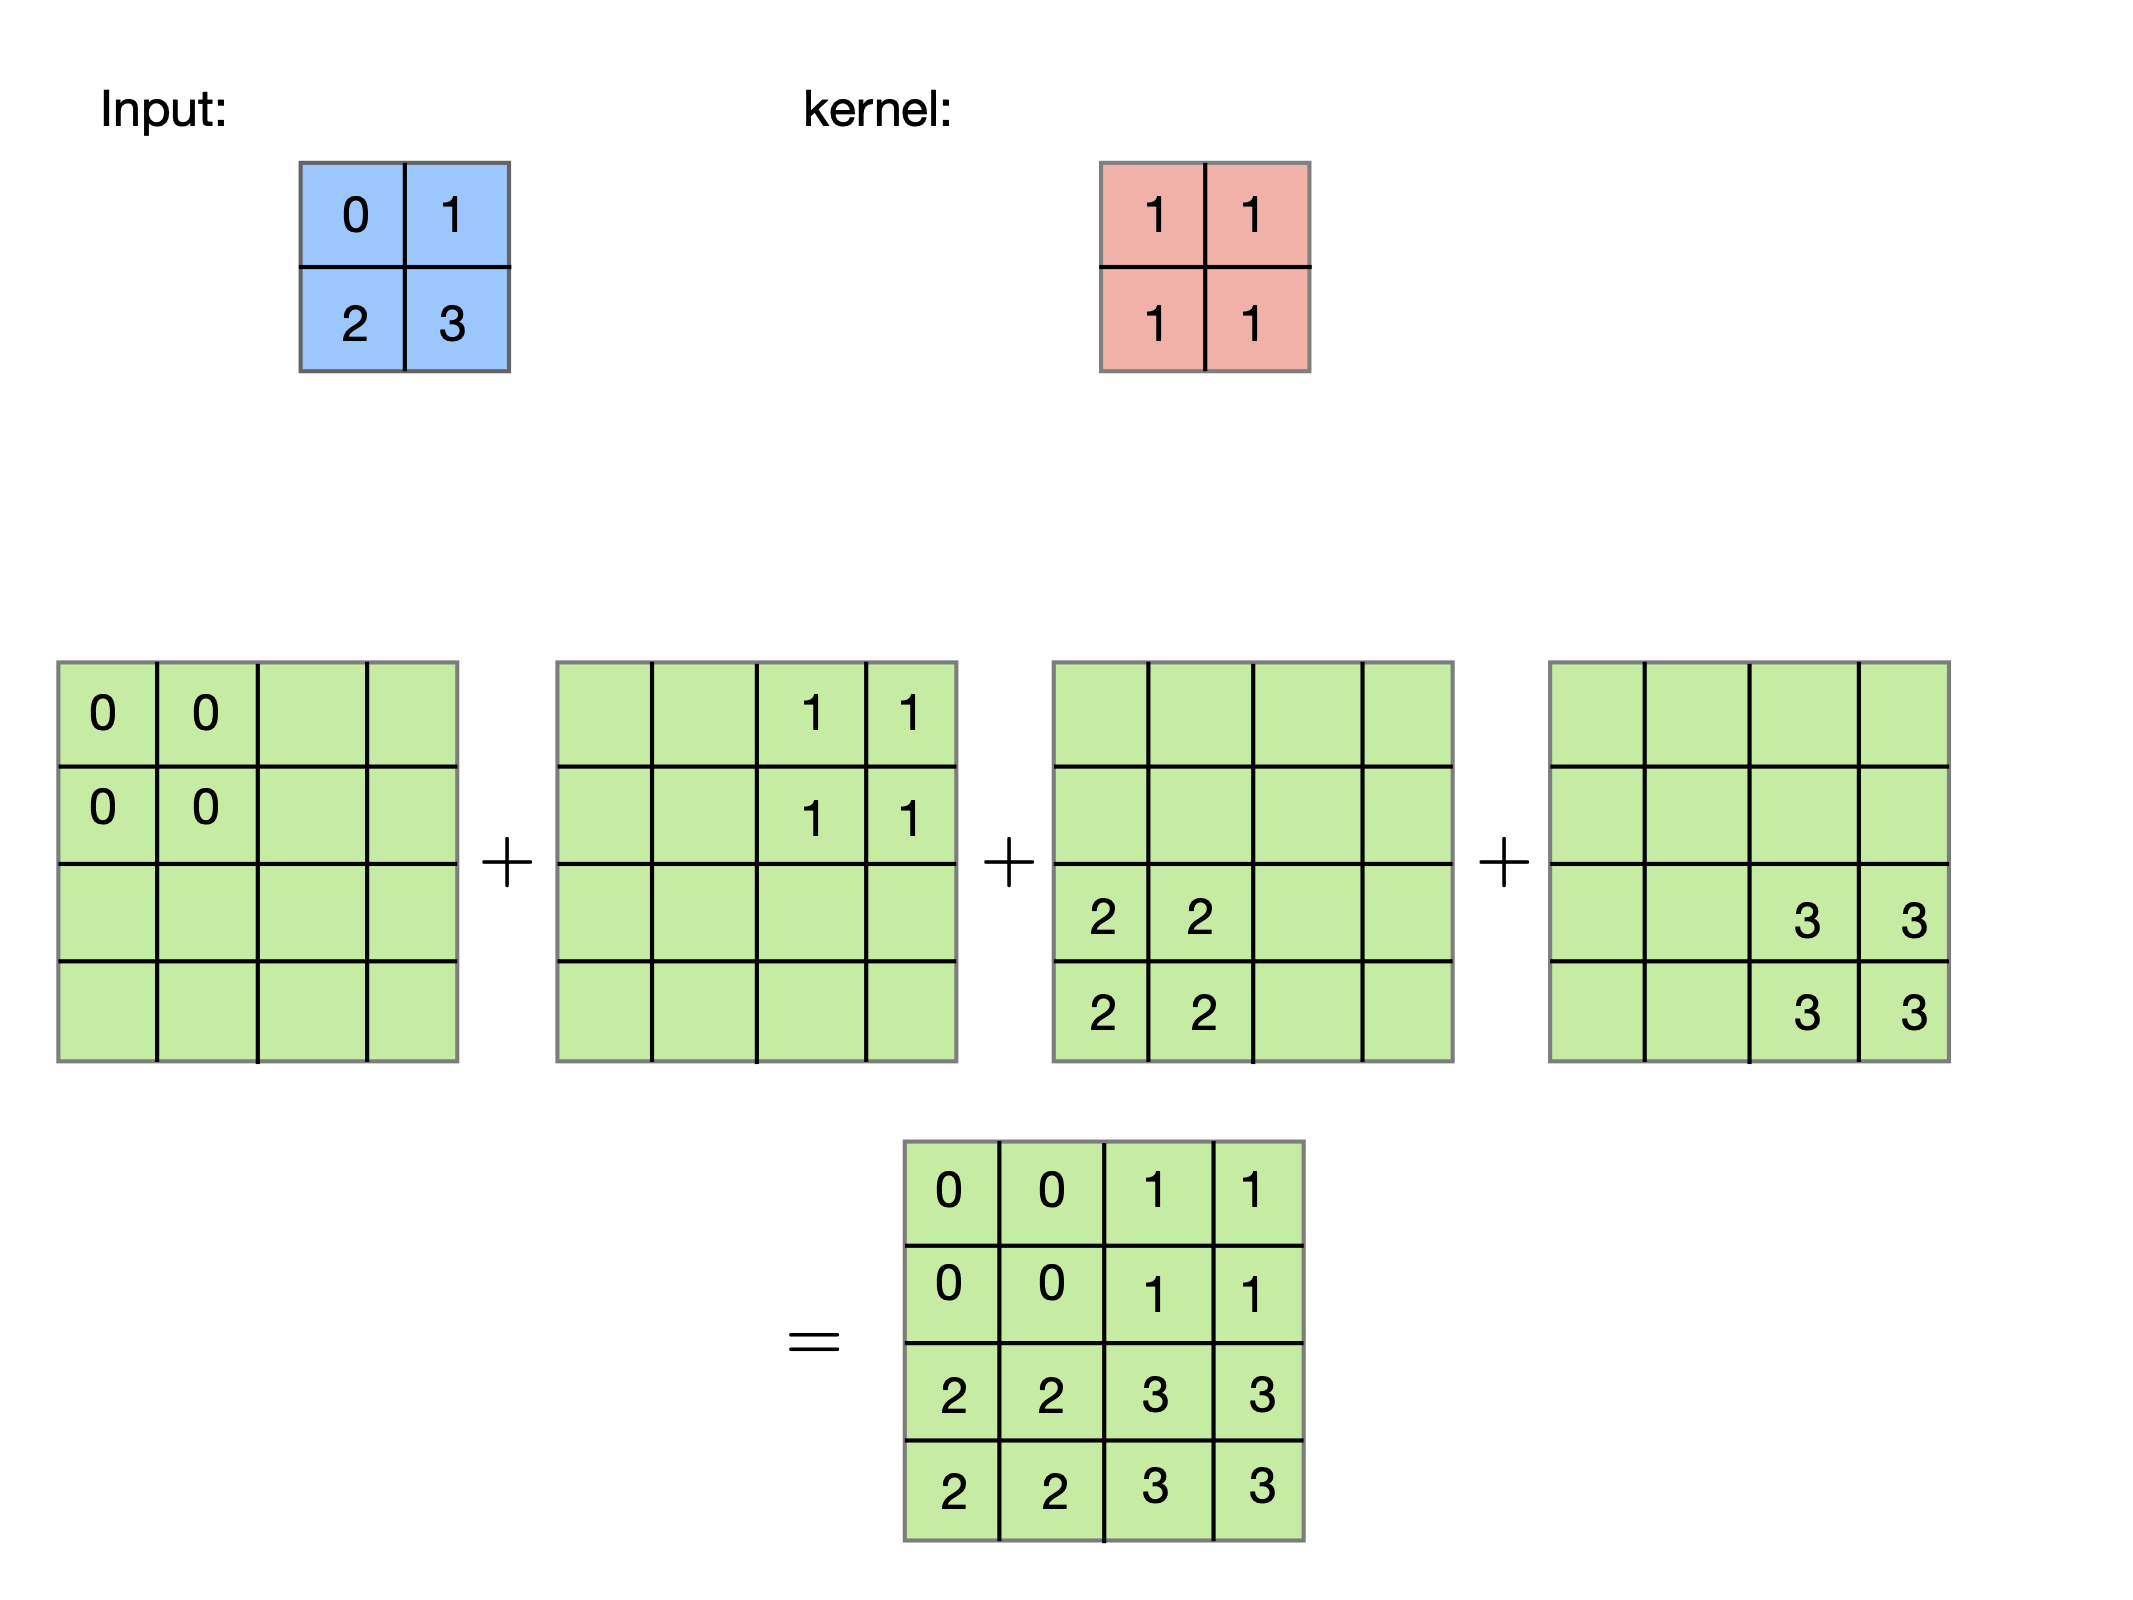

Padding just removes the rows/columns from the output according to the padding sizes given. E.g. if padding = (1,1) then we would remove 1 row from the top and bottom, and 1 column from left and right.

In [22]:
kernel_size = (2, 2)

# Define stride
stride = (2, 2)

# Define padding
padding = (1, 1)

# Define transposed convolution layer
transposed_conv = nn.ConvTranspose2d(in_channels=1,
                                     out_channels=1,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=padding,
                                     bias = False)

transposed_conv.weight.data = kernel

# Perform transposed convolution
output = transposed_conv(input)

# Display output
print("output \n", output)
print("\n output Shape", output.shape)

output 
 tensor([[[[0., 1.],
          [2., 3.]]]], grad_fn=<ConvolutionBackward0>)

 output Shape torch.Size([1, 1, 2, 2])


In [23]:
kernel_size = (6, 6)

# Define stride
stride = (2, 2)

# Define padding
padding = (1, 1)

# Define transposed convolution layer
transposed_conv = nn.ConvTranspose2d(in_channels=1,
                                     out_channels=1,
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=padding,
                                     bias = False)


# Perform transposed convolution
output = transposed_conv(input)

# Display output
print("output \n", output)
print("\n output Shape", output.shape)

output 
 tensor([[[[ 0.0000, -0.0165, -0.1037,  0.1161, -0.1087,  0.1454],
          [-0.3029,  0.5931, -0.3905,  0.4033,  0.1402,  0.1282],
          [-0.2075,  0.0275, -0.6852,  0.6978, -0.6400,  0.4349],
          [-0.2643,  0.0535, -0.4090,  0.1514, -0.0864,  0.0184],
          [-0.3134, -0.2277, -0.7916,  0.0599, -0.3096,  0.1029],
          [ 0.2698,  0.2113,  0.6859, -0.4594,  0.5312, -0.3025]]]],
       grad_fn=<ConvolutionBackward0>)

 output Shape torch.Size([1, 1, 6, 6])


Formula for the size of the output: assume that the kernel size is $(k_k, k_w)$ and the input size if $(i_h, i_w)$; also assume that the size of the stride is $s$ and the size of the padding is $p$. Then the size of the output $(o_h, o_w)$ is:

$$o_h = (i_h-1) \times s + k_h - 2p, \text{ and } o_w = (i_w - 1) \times s + k_w - 2p.$$

**Creating the Autoencoder with Conv2d and ConvTranspose2d layers:**

In [24]:
def conv_block(input_channels, output_channels):
    return nn.Sequential(
        nn.Conv2d(input_channels, output_channels, 3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2)  # reduce x-y dims by two; window and stride of 2
    )

def deconv_block(input_channels, output_channels, kernel_size):
    return nn.Sequential(
        nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride=2),
        nn.ReLU()
    )

class AE_conv(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            conv_block(1, 32),
            conv_block(32, 16),
            conv_block(16, 8)
        )
        self.decoder = nn.Sequential(
            deconv_block(8, 8, 3),
            deconv_block(8, 16, 2),
            deconv_block(16, 32, 2),
            nn.Conv2d(32, 1, 3, padding=1)  # final conv layer to decrease channel back to 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = torch.sigmoid(x)  # get pixels between 0 and 1
        return x

In [25]:
EPOCHS = 20
cmodel = AE_conv()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cmodel.parameters())
img_list = []

cmodel = cmodel.to(device)
cmodel.train()
for epoch in range(EPOCHS):
    losses = 0
    for batch, _ in train_dataloader:
        batch = batch.to(device)
        optimizer.zero_grad()
        y_hat = cmodel(batch)
        loss = criterion(y_hat, batch)
        loss.backward()
        optimizer.step()
        losses += loss.item()
    print(f"epoch: {epoch}, loss: {losses / len(train_dataloader):.4f}")

epoch: 0, loss: 0.1145
epoch: 1, loss: 0.1120
epoch: 2, loss: 0.1068
epoch: 3, loss: 0.0282
epoch: 4, loss: 0.0209
epoch: 5, loss: 0.0190
epoch: 6, loss: 0.0178
epoch: 7, loss: 0.0170
epoch: 8, loss: 0.0164
epoch: 9, loss: 0.0158
epoch: 10, loss: 0.0153
epoch: 11, loss: 0.0148
epoch: 12, loss: 0.0143
epoch: 13, loss: 0.0140
epoch: 14, loss: 0.0136
epoch: 15, loss: 0.0132
epoch: 16, loss: 0.0130
epoch: 17, loss: 0.0127
epoch: 18, loss: 0.0125
epoch: 19, loss: 0.0122


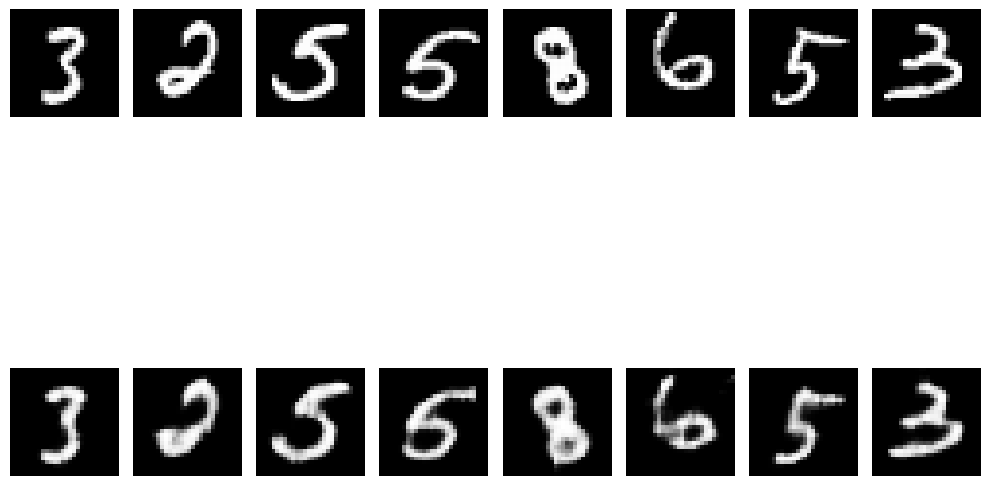

In [26]:
figure = plt.figure(figsize=(10, 10))
#figure = plt.subplots(2, 8)
data = data.to(device)
for i in range(8):
  input = data[i,:]
  plt.subplot(2
  , 8, i+1)
  plt.imshow(input.squeeze(0).cpu(), cmap='gray')
  plt.axis('off')

  y = cmodel(input)
  plt.subplot(2, 8, 8+i+1)
  plt.imshow(y.detach().squeeze(0).cpu().numpy(), cmap='gray')
  plt.axis('off')
plt.tight_layout()
plt.show()

In [27]:
print(cmodel)

AE_conv(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(8, 16, kernel_size=(2, 2), stride=(2, 2))
      (1): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2

In [28]:
summary(cmodel, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           4,624
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7              [-1, 8, 7, 7]           1,160
              ReLU-8              [-1, 8, 7, 7]               0
         MaxPool2d-9              [-1, 8, 3, 3]               0
  ConvTranspose2d-10              [-1, 8, 7, 7]             584
             ReLU-11              [-1, 8, 7, 7]               0
  ConvTranspose2d-12           [-1, 16, 14, 14]             528
             ReLU-13           [-1, 16, 14, 14]               0
  ConvTranspose2d-14           [-1, 32,

## **Image Generation:**

Here, $z_\text{new}$ is the average of the four laten representations obtained by encoding the four chosen images from the data set.

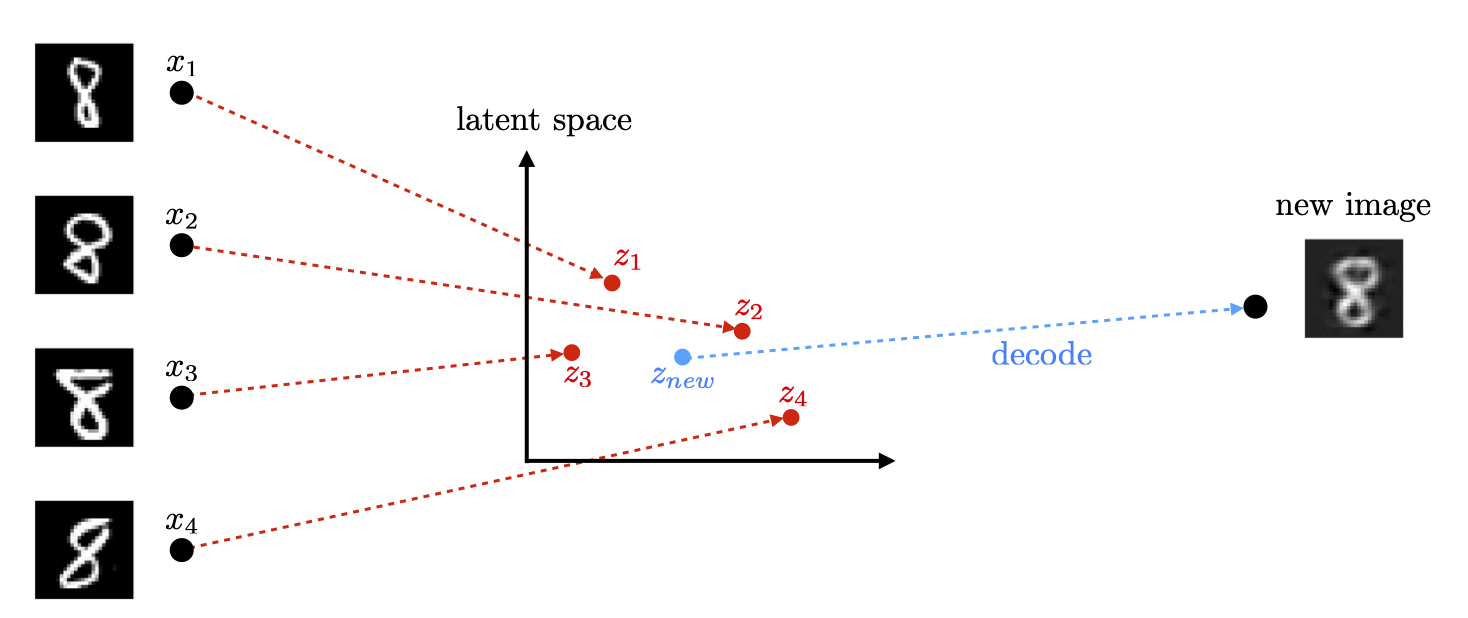

Let's take all the data points from class 8 and consider their latent representations.

In [29]:
eights = torch.tensor([])
for data, targets in train_dataloader:
  idx = targets == 8
  if(len(data[idx]) > 0):
    for i in data[idx]:
      eights = torch.cat([eights, i])
eights = eights.to(device)
eights_encoded = model64.encoder(eights.view(eights.shape[0],-1))

Let's now take 4 random points from the latent vectors, and combine them randomly. Then, we will decode the resulting vector. This will give us a **new image that does not exist** in out data set. In this way, we are **randomly sampling** from the latent space to **create new images**.

(-0.5, 27.5, 27.5, -0.5)

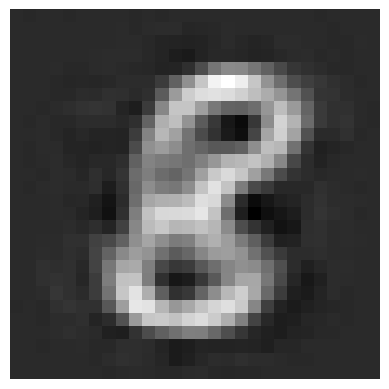

In [30]:
idx = torch.randint(eights_encoded.shape[0], (4,))
new_latent = torch.sum(eights_encoded[idx,:], dim = 0)/4.0
new_image = model64.decoder(new_latent)

plt.imshow(new_image.detach().view(28,28).squeeze(0).cpu().numpy(), cmap='gray')
plt.axis('off')